# Prepare
## Dataset loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import Callback
train_raw = pd.read_excel('/home/competition/data/data/ai_competition_train.xlsx')
test_raw = pd.read_excel('/home/competition/data/data/ai_competition_test.xlsx')

train = np.array(train_raw['flux'])
test = np.array(test_raw['flux'])

print(train.shape, test.shape)

2023-10-12 15:09:55.929756: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-12 15:09:55.931859: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-12 15:09:55.973252: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-12 15:09:55.974073: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 15:09:56.817363: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

(5479,) (60,)


## Nan -> zero (Only train)

In [2]:
# NaN 값을 0.0으로 대체
nan_indices = np.isnan(train)
_mask = np.zeros(len(train))
train[nan_indices] = _mask[nan_indices]

# NaN 값을 대체한 결과 확인
print(train)
print(np.mean(train))
print("NaN 값의 개수:", np.sum(np.isnan(test)))


[ 94.8    96.93   97.71  ...   0.    128.634 143.651]
78.29537461215551
NaN 값의 개수: 0


## Cut zero (Only train)
- 인위적인 이동평균을 넣어주는 것은 오히려 악영향이라고 생각 > 끊어진 부분 강제로 이어붙임으로서 그것 또한 노이즈하고 생각하기

In [3]:
train_cut = train[train != 0]
print(train_cut.shape)
print(np.mean(train_cut))

(4228,)
101.46176856669818


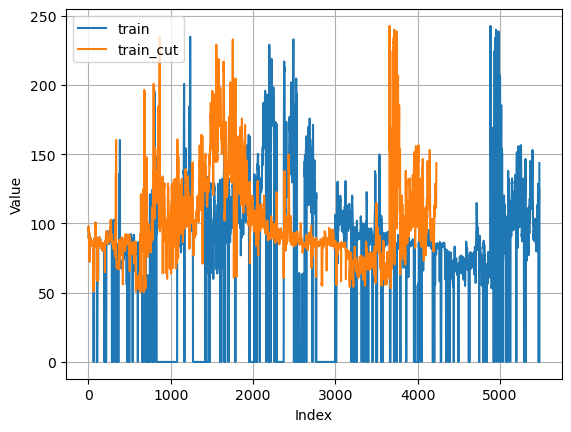

In [4]:
plt.figure()
plt.plot(train, label='train')
plt.plot(train_cut, label='train_cut')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

## Subtract Mean

In [5]:
train_cut_sub_mean = train_cut - np.mean(train_cut)
print(np.mean(train_cut_sub_mean), np.var(train_cut_sub_mean))

test_mean = np.mean(test)
test_sub_mean = test - test_mean
print(np.mean(test_sub_mean), np.var(test_sub_mean))


1.118583833779382e-14 926.6917847239334
1.4210854715202004e-14 234.5757282247222


## Make dataset

In [7]:
INPUT_DAYS = 60

train_x = np.empty([INPUT_DAYS, 1])
train_y = np.empty([1, 1])

print("x and y shape :", train_x.shape, train_y.shape)
for i in range(len(train_cut_sub_mean) - INPUT_DAYS - 1):
    train_x = np.concatenate(
        (train_x, train_cut_sub_mean[i:i+INPUT_DAYS, np.newaxis]), axis=1)
    train_y = np.concatenate(
        (train_y, train_cut_sub_mean[np.newaxis, i+INPUT_DAYS+1, np.newaxis]), axis=1)

print("x and y shape :", train_x.shape, train_y.shape)

train_x = train_x.T
train_y = train_y.T
print("x and y shape :", train_x.shape, train_y.shape)


x and y shape : (60, 1) (1, 1)
x and y shape : (60, 4168) (1, 4168)
x and y shape : (4168, 60) (4168, 1)


---

# Model

In [8]:
model = keras.Sequential()
model.add(keras.layers.LSTM(units=50, input_shape=(INPUT_DAYS, 1)))
model.add(keras.layers.Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')


In [9]:
loss_history = []
rmse_history = []

class RMSECallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        rmse_history.append(tf.sqrt(logs['loss']))


class LossHistory(Callback):
    def on_epoch_end(self, epoch, logs=None):
        loss_history.append(logs['loss'])

rmse_callback = RMSECallback()
loss_callback = LossHistory()


In [10]:
model.fit(train_x, train_y, epochs=50, batch_size=256,
          callbacks=[rmse_callback, loss_callback])


Epoch 1/50
17/17 [==============================] - 2s 33ms/step - loss: 941.4738
Epoch 2/50
17/17 [==============================] - 1s 36ms/step - loss: 891.5932
Epoch 3/50
17/17 [==============================] - 1s 38ms/step - loss: 852.6827
Epoch 4/50
17/17 [==============================] - 1s 39ms/step - loss: 814.7819
Epoch 5/50
17/17 [==============================] - 1s 40ms/step - loss: 777.7247
Epoch 6/50
17/17 [==============================] - 1s 39ms/step - loss: 742.3447
Epoch 7/50
17/17 [==============================] - 1s 38ms/step - loss: 712.2036
Epoch 8/50
17/17 [==============================] - 1s 37ms/step - loss: 683.5150
Epoch 9/50
17/17 [==============================] - 1s 38ms/step - loss: 655.4432
Epoch 10/50
17/17 [==============================] - 1s 37ms/step - loss: 631.0203
Epoch 11/50
17/17 [==============================] - 1s 39ms/step - loss: 609.8699
Epoch 12/50
17/17 [==============================] - 1s 38ms/step - loss: 589.5757
Epoch 13/50
1

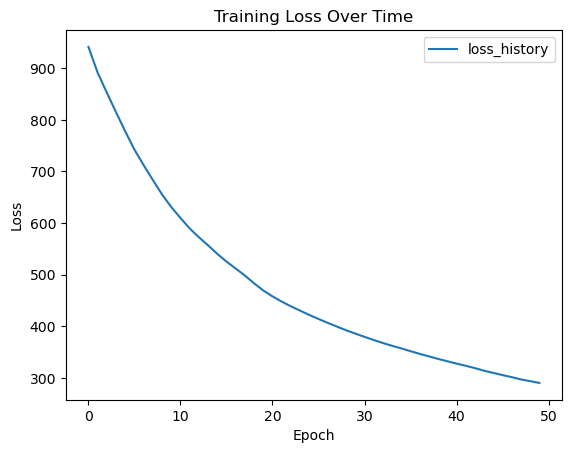

In [19]:

plt.plot(loss_history)
plt.title('Training Loss Over Time')
plt.legend(['loss_history', 'rmse_history'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


---

# Prediction

- input 60개로 61번째 예측
- 2번째 ~ 61번째로, 62번째 예측
- 90번째를 예측할 때 까지 반복하고, 61~90번째를 제출

In [12]:
final_result = test_sub_mean
print(final_result.shape)
for i in range(30):
    _single_output = model(
        final_result[np.newaxis, i:i+INPUT_DAYS, np.newaxis]).numpy()
    final_result = np.concatenate((final_result, _single_output[0]), axis=0)    


(60,)
0 (61,) -14.007048606872559
1 (62,) -17.1068115234375
2 (63,) -20.182920455932617
3 (64,) -20.208694458007812
4 (65,) -17.46055793762207
5 (66,) -13.503861427307129
6 (67,) -8.618880271911621
7 (68,) -1.6823354959487915
8 (69,) 7.454297065734863
9 (70,) 17.124492645263672
10 (71,) 25.25800895690918
11 (72,) 26.26746368408203
12 (73,) 24.849395751953125
13 (74,) 22.765380859375
14 (75,) 20.04078483581543
15 (76,) 17.08473014831543
16 (77,) 14.197952270507812
17 (78,) 10.725479125976562
18 (79,) 6.614808082580566
19 (80,) 2.550184726715088
20 (81,) -0.4910926818847656
21 (82,) -2.7618541717529297
22 (83,) -4.005128383636475
23 (84,) -4.599608898162842
24 (85,) -3.831404209136963
25 (86,) -1.2203363180160522
26 (87,) 3.181142807006836
27 (88,) 9.109807014465332
28 (89,) 17.526962280273438
29 (90,) 25.27052879333496


## Subtract mean했던거 다시 더해주기

In [15]:
_summit = final_result[-30:]
print(np.mean(_summit))
_summit = _summit + test_mean
print(np.mean(_summit))
print(_summit.shape)
print(_summit)

4.011362806955973
137.99334614028925
(30,)
[119.97493473 116.87517181 113.79906288 113.77328888 116.5214254
 120.47812191 125.36310306 132.29964784 141.4362804  151.10647598
 159.23999229 160.24944702 158.83137909 156.74736419 154.02276817
 151.06671348 148.1799356  144.70746246 140.59679142 136.53216806
 133.49089065 131.22012916 129.97685495 129.38237444 130.15057912
 132.76164702 137.16312614 143.09179035 151.50894561 159.25251213]


## output xlsx file 생성

In [17]:
import datetime

current_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")


# 주어진 벡터 데이터
data = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
        11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
        21, 22, 23, 24, 25, 26, 27, 28, 29, 30]

# 데이터를 Pandas DataFrame으로 변환
df = pd.DataFrame({'date': data, 'flux': _summit})

# DataFrame을 엑셀 파일로 내보내기
file_name = f'output_{current_time}.xlsx'
df.to_excel(file_name, index=False)
